# Recurrent Neural Network

In [44]:
#import packages
import pandas as pd
import numpy as np
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import codecs
import string
import os
import re
import seaborn as sns
import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support

from keras.preprocessing import sequence
from keras import Sequential
from keras.optimizers import Adam
from keras import regularizers

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.layers import Embedding, LSTM, Dense, Dropout,GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Activation, Bidirectional, RepeatVector, Input

In [45]:
#load data
df = pd.read_csv('cleaned_text.csv')

In [46]:
df.head()

,Target,Text
0,Rejected,more than 10600 megawatts of solar power were ...
1,Rejected,smi reports 6 key reasons to attend this years...
2,Completed,dive insight utilities are beginning to see th...
3,Completed,united renewable energy and constellation an e...
4,Completed,march 30 renewables now juwi hellas a unit of ...


In [47]:
df['Length'] = df['Text'].apply(len)
df.sort_values(by='Length', ascending=False).head(10)

,Target,Text,Length
2272,Rejected,correspondence to professor quancheng kan depa...,34541
798,Completed,boralex announces agreement to acquire invener...,28549
2022,Rejected,equity research weekly report july 20 2018 the...,16606
1313,Rejected,the university of michigan partnered with dte ...,15618
1316,Rejected,html xmlnsvurnschemasmicrosoftcomvml xmlnsourn...,14353
2131,Rejected,htmlh3redt energy plc red redt sign deal for 7...,13898
1056,Rejected,abstracttop tier growth execution and now topt...,13648
2601,Rejected,far off the beaten track life in the remote va...,13643
477,Completed,delhiheadquartered renewable energy firm hero ...,13471
2144,Completed,by ben potter july 25 financial review the nat...,13126


In [48]:
# what are our shortest sentences?
df.sort_values(by='Length').head(5)

,Target,Text,Length
951,Rejected,0 jun282018 1620 gmt,20
1214,Rejected,copyright 2018 rbc0 aug082018 1135 gmt,38
1155,Rejected,copyright 2018 rbc0 aug022018 1204 gmt,38
1518,Rejected,provider id 002126030 aug022018 1120 gmt,40
136,Rejected,copyright 2018 bmo capital markets0 aug022018 ...,54


## Data Preprocessing

- check classes are balanced

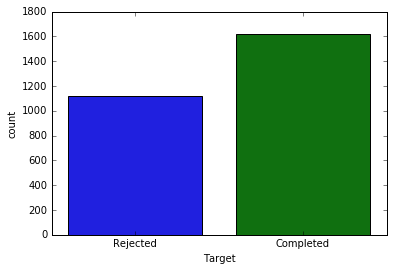

In [49]:
#plot the distribution of the training data
sns.countplot(df['Target'])

The imbalance of classes is effecting how our model trains on the training data, and thus its performance. There are various means to balance classes for classification problems. One of those means is to downsample the majority class, ie, when creating training data for the model, feed it some subset of all the observations in the majority class. The problem with this method is that you tend to throw away valuable data.

A nice alternative is upsampling the minority class, ie, repeating some observations from that class to simulate a greater dataset. The problem with this method is that the model tends to overfit to the training data as it is fed duplicate observations during training.

In [50]:
from sklearn.utils.multiclass import type_of_target
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X = df['Text']
X=X.reshape(-1,1)
y = df['Target']
type_of_target(y)
X_resampled, y_resampled = rus.fit_resample(X, y)

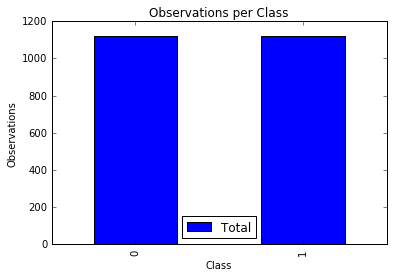

In [51]:
df2 = pd.DataFrame([], columns=['Class','Total'])
df2['Class'] = ["Rejected","Completed"]
df2['Total'] = [pd.value_counts(y_resampled)[0],pd.value_counts(y_resampled)[1]]
df2.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations')
plt.title('Observations per Class') #We therefore have imnbalanced classes, but we will continue regarless
plt.show()

In [52]:
#Creating pandas dataframe from numpy array
dataset = pd.DataFrame({'Text':X_resampled[:,0],'Target':y_resampled[:,]})

In [53]:
#split up the training and test data
x_train, x_test, y_train, y_test = train_test_split(dataset['Text'],
                                     dataset['Target'],
                                     test_size=0.20,
                                     random_state=80)

In [54]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y_train = encoder.fit_transform(y_train)
Y_test = encoder.fit_transform(y_test)

## Unable to Use TFIDF Matrix

In [55]:
from keras.preprocessing.text import Tokenizer
# load whole corpus of words
all_text = dataset['Text'].values

In [56]:
#how many words in the text set


In [57]:
max_len=None
num_words=5000

def vectorize (train_texts,val_texts):
    
    a=train_texts.to_frame()
    b=val_texts.to_frame()
    text = np.append(a,b)
    tok = Tokenizer(num_words=num_words)
    tok.fit_on_texts(text)
    #prepare text for CNN
    cnn_texts_seq = tok.texts_to_sequences(text)
    cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)
    x_vec_train = cnn_texts_mat[0:len(x_train),]
    x_vec_test = cnn_texts_mat[0:-len(x_train),]
    return(x_vec_train, x_vec_test)

In [58]:
X_train, X_test =vectorize(x_train,x_test)

In [59]:
num_words = X_train.max()+1
X_train, X_test =vectorize(x_train,x_test)

In [60]:
len(X_train[1])

4122

## Run Recurrent Neural Network 

In [61]:
num_words = X_train.max()+1
max_len= len(X_train[1])
embedding_size=64
coef=1
drops = np.array([0.25,0.1,0.2,0.02,0.15])*coef

model = Sequential()
#model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words)))
model.add(Embedding(num_words,embedding_size, input_length=max_len))
model.add(Dropout(drops[0]))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dropout(drops[1]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(drops[2]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drops[3]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(drops[4]))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 4122, 64)          320000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 4122, 64)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
__________

In [62]:
batch_size = 130
num_epochs = 10

model.compile(loss='binary_crossentropy', 
              #optimizer= Adam(lr=1e-03), 
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.4)
history = history.history
val_acc = history['val_acc'][-1]
val_loss = history['val_loss'][-1]
print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))

Train on 1077 samples, validate on 718 samples
Epoch 1/10
1077/1077 [==============================] - 405s 376ms/step - loss: 0.6929 - acc: 0.5070 - val_loss: 0.6940 - val_acc: 0.4875
Epoch 2/10


KeyboardInterrupt: 

In [ ]:
final_loss, final_acc = model.evaluate(X_train,Y_train, verbose=0)
print("Train loss: {0:.2f}, Train accuracy: {1:.2f}%".format(final_loss, final_acc*100))

In [ ]:
final_loss, final_acc = model.evaluate(X_test,Y_test,verbose=0)
print("Test loss: {0:.2f}, Test accuracy: {1:.2f}%".format(final_loss, final_acc*100))

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict_classes(X_test)

#fetch predictions
preds=predictions.tolist()
y_lbls=Y_test.tolist()

cm_1 = confusion_matrix(preds,y_lbls)
print(pd.DataFrame(cm_1))